<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/7%20Feature%20selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature selection**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for grid
!pip install geopy -q
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# CatBoost
!pip install catboost -q
from catboost import CatBoostRegressor, Pool
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
# RandomForest
from sklearn.ensemble import RandomForestRegressor
# Linear Regression+l1 Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
# LightGBM
import lightgbm as lgb





from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


!pip -qq install category_encoders
from category_encoders import TargetEncoder


# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_5.xlsx', engine='openpyxl')

In [2]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments5.pkl -q

with open('apartments5.pkl', 'rb') as f:
    apartments = pickle.load(f)


In [3]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19664 entries, 0 to 19663
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Listing ID            19664 non-null  category      
 1   Host Since            19664 non-null  datetime64[ns]
 2   Host Response Time    10313 non-null  object        
 3   Host Response Rate    10313 non-null  float64       
 4   Is Superhost          19664 non-null  object        
 5   neighbourhood         19664 non-null  object        
 6   Neighborhood Group    19664 non-null  object        
 7   Postal Code           19664 non-null  category      
 8   Latitude              19664 non-null  float64       
 9   Longitude             19664 non-null  float64       
 10  Is Exact Location     19664 non-null  object        
 11  Property Type         19664 non-null  object        
 12  Room Type             19664 non-null  object        
 13  Accomodates     

This is an automated posting

drop notinformative columns Encodinf

In [4]:
apartments.drop(columns=['Host Since','First Review', 'Last Review','Reviews', 'Latitude_Bin', 'Longitude_Bin', 'Latitude_Bin2', 'Longitude_Bi2n','Listing ID'], inplace=True)

apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Property Type'] = apartments['Property Type'].replace({'Apartment': 1, 'Condominium': 0}).fillna(0).astype(int)
apartments['Room Type'] = apartments['Room Type'].replace({'Private room': 1, 'Entire home/apt': 0}).fillna(0).astype(int)

apartments['Host Response Time'] = apartments['Host Response Time'].replace(
    {'within an hour':0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3 }).fillna(3).astype(int)


In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

Value counts for column 'Listing ID' :
Listing ID
10002699    1
30934593    1
30947505    1
30946969    1
30946705    1
           ..
20716366    1
20716294    1
20710491    1
20710283    1
9996186     1
Name: count, Length: 19664, dtype: int64
NaN values: 0 


Value counts for column 'neighbourhood' :
neighbourhood
NeukÃ¶lln                3182
Prenzlauer Berg          2550
Kreuzberg                2509
Friedrichshain           2460
Mitte                    1749
Wedding                  1316
SchÃ¶neberg               935
Moabit                    715
Charlottenburg            696
Wilmersdorf               400
Pankow                    272
Rummelsburg               223
Tempelhof                 220
WeiÃensee                181
Lichtenberg               166
Alt-Treptow               156
Tiergarten                153
Steglitz                  135
Reinickendorf             133
Westend                    89
Lichterfelde               89
Friedenau                  77
Baumschulenweg        

# **Random forest**
**Used Target Encoding**

In [35]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

for col in col_train_obj:
    X_train[col] = X_train[col].astype('category').cat.add_categories('abr@cadabra').fillna('abr@cadabra')
    # Change the data type to 'category' before using .cat accessor

for col in col_test_obj:
    X_test[col] = X_test[col].astype('category').cat.add_categories('abr@cadabra').fillna('abr@cadabra')
    # Change the data type to 'category' before using .cat accessor

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=15,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', RandomForestRegressor(n_jobs=-1,
                              n_estimators = 300,
                              #max_depth = 12,
                              min_impurity_decrease = 0.05,
                              min_samples_split = 5,
                              max_features = 'sqrt',
                              random_state = 142
                              ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n')

print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred), '\n')

print(f'Train R²:' , r2_score(y_train, y_train_pred))
print(f'Test R²:' , r2_score(y_test, y_test_pred))



Train RMSE: 13.318791290841792
Test RMSE: 26.560146836217573 

Train MAE: 9.518861766012243
Test MAE: 17.11138778599543
Train R²: 0.8814194901039738
Test R²: 0.5246413601898651


                 Feature  Importance  Rating_Importance
12             Room Type    0.140096                  1
13           Accomodates    0.125662                  2
3                Bin-Bin    0.103261                  3
15              Bedrooms    0.092436                  4
16                  Beds    0.053849                  5
17       Guests Included    0.050089                  6
4              Bin2-Bin2    0.045747                  7
2            Postal Code    0.034324                  8
35  Distance_from_center    0.029380                  9
14             Bathrooms    0.028440                 10
31      Host Since Years    0.025132                 11
9              Longitude    0.024380                 12
8               Latitude    0.023770                 13
32     Last Review Years    0.022161                 14
0          neighbourhood    0.019879                 15
30         Polarity_mean    0.019100                 16
29       Polarity_median    0.016752            

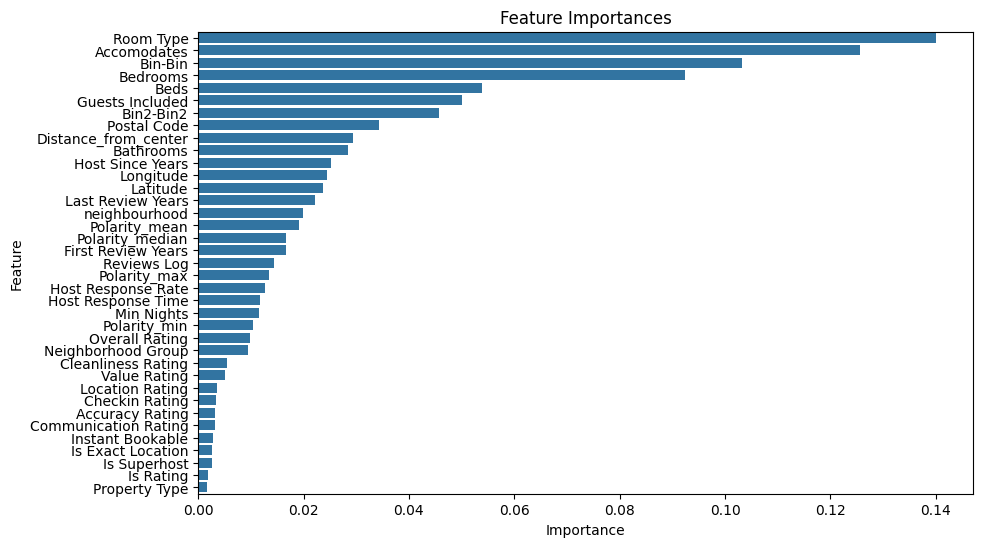

In [33]:
# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace('mean_target_encode__', '').str.replace('remainder__', '')
feature_importance_df['Rating_Importance'] = feature_importance_df['Importance'].rank(ascending=False).astype(int)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# **Lasso**

## Used One-Hot Encodind

In [99]:
# Разделение на фичи и таргет
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: One-Hot инкодинг
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, max_iter=100000, random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}", '\n')

#для Price Log
# y_train_e = np.expm1(y_train)
# y_train_pred_e = np.expm1(y_train_pred)
# y_test_e = np.expm1(y_test)
# y_test_pred_e = np.expm1(y_test_pred)
# train_r2_e = r2_score(y_train_e, y_train_pred_e)
# test_r2_e = r2_score(y_test_e, y_test_pred_e)
# print(f"Train R^2 e: {train_r2_e:.3f}")
# print(f"Test R^2 e: {test_r2_e:.3f}")

# Важность признаков
model = pipeline.named_steps['model']
feature_names = (numerical_cols.tolist() +
                 pipeline.named_steps['preprocessor'].named_transformers_['cat']
                 .named_steps['onehot'].get_feature_names_out(categorical_cols).tolist())
importance = list(zip(feature_names, abs(model.coef_)))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, coef in importance_sorted:
    print(f"{feature}: {coef:.3f}")

Train MSE: 640.410
Test MSE: 722.989
Train MAE: 16.884
Test MAE: 17.519
Train R^2: 0.572
Test R^2: 0.513 

Feature importance (sorted):
Bin-Bin_98-58: 46.848
Bin2-Bin2_51-30: 28.142
Bin2-Bin2_47-28: 22.199
Postal Code_10629.0: 19.670
neighbourhood_Potsdamer Platz: 19.493
Bin-Bin_109-58: 17.874
Postal Code_14195.0: 17.084
Bin2-Bin2_45-30: 16.384
Bin-Bin_96-39: 15.272
Bin-Bin_86-64: 14.915
Bin2-Bin2_49-29: 14.826
Bin2-Bin2_54-29: 13.554
Bin-Bin_103-62: 12.060
neighbourhood_Mitte: 11.964
Postal Code_10117.0: 11.744
Bin2-Bin2_52-33: 11.369
Postal Code_10707.0: 11.103
Postal Code_10589.0: 10.712
Room Type: 10.474
Bin-Bin_87-67: 9.958
Postal Code_10785.0: 9.954
Bin2-Bin2_44-21: 9.327
Bin-Bin_118-62: 9.078
Bin2-Bin2_44-24: 9.062
Bin-Bin_104-65: 8.919
Bin-Bin_113-66: 8.848
Accomodates: 8.738
Bin2-Bin2_52-30: 8.294
Bin2-Bin2_47-31: 8.212
Postal Code_10623.0: 8.051
Postal Code_10719.0: 7.846
Bin-Bin_110-51: 7.834
Bin2-Bin2_35-29: 7.608
Bin-Bin_98-73: 7.573
Bedrooms: 7.207
Bin2-Bin2_47-30: 6.987


## Terget Encoding

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import TargetEncoder

X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: Target Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder(min_samples_leaf=10,
                                     #smoothing=10,
                                     handle_missing='value',
                                     handle_unknown='value'

    ))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, max_iter=100000, random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")

# Важность признаков
model = pipeline.named_steps['model']
importance = list(zip(numerical_cols.tolist() + categorical_cols.tolist(), abs(model.coef_)))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, coef in importance_sorted:
    print(f"{feature}: {coef:.3f}")


Train MSE: 612.361
Test MSE: 759.687
Train MAE: 16.775
Test MAE: 18.199
Train R^2: 0.591
Test R^2: 0.488
Feature importance (sorted):
Room Type: 9.553
Accomodates: 8.376
Bedrooms: 6.545
Guests Included: 4.692
Reviews Log: 3.332
Value Rating: 3.091
Bathrooms: 3.059
Distance_from_center: 2.780
Host Response Time: 2.536
Cleanliness Rating: 2.160
Last Review Years: 2.094
Min Nights: 1.785
Overall Rating: 1.604
Is Superhost: 1.261
Longitude: 1.136
Bin-Bin: 0.986
Polarity_mean: 0.914
Latitude: 0.819
Host Since Years: 0.773
Property Type: 0.756
First Review Years: 0.615
Host Response Rate: 0.605
Is Rating: 0.355
Is Exact Location: 0.276
Accuracy Rating: 0.131
Polarity_median: 0.113
Polarity_min: 0.098
Location Rating: 0.096
Communication Rating: 0.095
Instant Bookable: 0.088
Neighborhood Group: 0.081
neighbourhood: 0.080
Postal Code: 0.065
Polarity_max: 0.047
Beds: 0.043
Bin2-Bin2: 0.043
Checkin Rating: 0.041


                                   Feature  Importance
11                    remainder__Room Type  -19.072167
8                     remainder__Longitude  -14.717272
14                     remainder__Bedrooms   12.760017
13                    remainder__Bathrooms    9.972818
12                  remainder__Accomodates    6.638966
16              remainder__Guests Included    6.630135
29                remainder__Polarity_mean    5.000239
24                 remainder__Value Rating   -4.106765
10                remainder__Property Type   -4.016373
6                  remainder__Is Superhost    3.355687
5            remainder__Host Response Rate   -3.224562
33                  remainder__Reviews Log   -2.448124
20           remainder__Cleanliness Rating    2.254306
31            remainder__Last Review Years   -2.134414
4            remainder__Host Response Time   -1.887282
28              remainder__Polarity_median    1.844214
34         remainder__Distance_from_center   -1.117216
3         

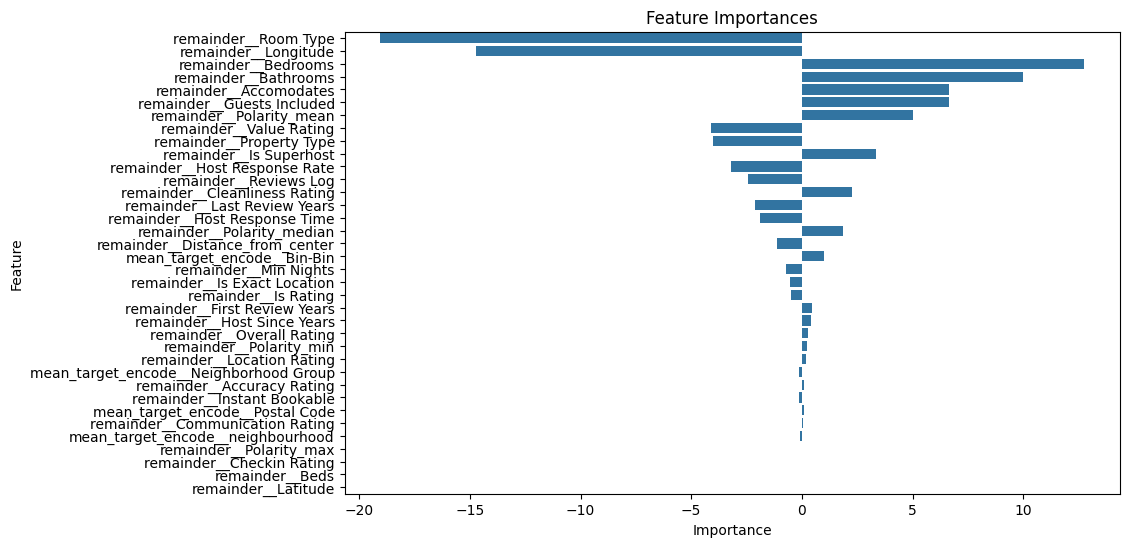

In [ ]:
# prompt: важность признаков для Lasso и график

# Get feature importances
importances = pipeline.named_steps['model'].coef_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', key = abs,  ascending=False)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# XGBRegressor

## One-Hot Encoding

In [114]:
# Разделение на фичи и таргет
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)


# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Выделение числовых и категориальных признаков
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Пайплайн для числовых данных: заполнение NaN и нормализация
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных данных: One-Hot инкодинг
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore' ))
])

# Объединение пайплайнов для числовых и категориальных данных
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Общий пайплайн: предобработка данных и обучение модели
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=200,
                           learning_rate=0.05,
                           colsample_bylevel = 0.3, # доля признаков
                           max_depth = 6, # максимальная глубина
                           gamma = 0.1,

                           random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Оценка модели
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Вывод метрик
print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")

# Важность признаков
model = pipeline.named_steps['model']
importance = list(zip(numerical_cols.tolist() +
                      pipeline.named_steps['preprocessor'].named_transformers_['cat']
                      .named_steps['onehot'].get_feature_names_out(categorical_cols).tolist(),
                      model.feature_importances_))
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

print("Feature importance (sorted):")
for feature, importance in importance_sorted:
    print(f"{feature}: {importance:.3f}")


Train MSE: 404.555
Test MSE: 664.886
Train MAE: 13.930
Test MAE: 16.488
Train R^2: 0.730
Test R^2: 0.552
Feature importance (sorted):
Room Type: 0.059
Bedrooms: 0.038
Accomodates: 0.030
Bathrooms: 0.027
Beds: 0.023
Guests Included: 0.018
neighbourhood_Mitte: 0.014
Postal Code_10117.0: 0.013
Neighborhood Group_Pankow: 0.007
Bin-Bin_83-73: 0.006
Neighborhood Group_NeukÃ¶lln: 0.006
Neighborhood Group_Mitte: 0.006
Bin2-Bin2_51-23: 0.006
neighbourhood_Wedding: 0.005
Bin-Bin_80-69: 0.005
Distance_from_center: 0.005
Bin2-Bin2_43-25: 0.005
Bin2-Bin2_45-27: 0.005
neighbourhood_Pankow: 0.005
Bin2-Bin2_47-28: 0.005
Host Response Rate: 0.005
neighbourhood_NeukÃ¶lln: 0.005
Bin2-Bin2_47-38: 0.005
Bin-Bin_121-63: 0.004
Bin-Bin_88-52: 0.004
Postal Code_10245.0: 0.004
Bin2-Bin2_44-24: 0.004
Bin2-Bin2_42-27: 0.004
Postal Code_10119.0: 0.004
Postal Code_10243.0: 0.004
Host Response Time: 0.004
Bin-Bin_90-75: 0.004
neighbourhood_Marzahn: 0.004
Bin-Bin_127-60: 0.004
Postal Code_10969.0: 0.004
Bin2-Bin2_56-

# CatBoost
for CatBost no nessery to make encoding and Nan

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# !pip install catboost -q
# from catboost import CatBoostRegressor, Pool  # Now CatBoost is available

X = apartments.drop(['Price'], axis=1)
y = apartments['Price']

num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(exclude='number').columns

for col in cat_features:
    if X[col].dtype != 'str':
        X[col] = X[col].astype(str)

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Convert cat_features to a list
cat_features = cat_features.tolist()  # This is the key change

# Создаем модели для обучающей и тестовой выборок с указанием категориальных признаков
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Инициализируем и обучаем модель
model = CatBoostRegressor(iterations=2000, learning_rate=0.02, depth=6, verbose=100)
model.fit(train_pool)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики для обучающей выборки
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Вычисляем метрики для тестовой выборки
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Выводим метрики на обучающей выборке
print("Metrics on Training Set:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R^2 Score: {train_r2}")

# Выводим метрики на тестовой выборке
print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R^2 Score: {test_r2}")


# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature_name, importance in feature_importance_tuples:
    print(f'Feature: {feature_name}, Importance: {importance}')


0:	learn: 38.3285616	total: 30.1ms	remaining: 1m
100:	learn: 26.3184491	total: 2.04s	remaining: 38.4s
200:	learn: 25.0096328	total: 5.67s	remaining: 50.7s
300:	learn: 24.4625071	total: 9.17s	remaining: 51.8s
400:	learn: 24.0842339	total: 12.8s	remaining: 51.1s
500:	learn: 23.7513489	total: 14.8s	remaining: 44.3s
600:	learn: 23.4325902	total: 17.5s	remaining: 40.7s
700:	learn: 23.1238748	total: 20.6s	remaining: 38.1s
800:	learn: 22.8808752	total: 22.6s	remaining: 33.8s
900:	learn: 22.6472165	total: 24.5s	remaining: 29.9s
1000:	learn: 22.4356655	total: 26.5s	remaining: 26.5s
1100:	learn: 22.2501518	total: 28.5s	remaining: 23.2s
1200:	learn: 22.0619013	total: 31.2s	remaining: 20.8s
1300:	learn: 21.8950085	total: 34.2s	remaining: 18.4s
1400:	learn: 21.7378900	total: 36.2s	remaining: 15.5s
1500:	learn: 21.5782577	total: 38.1s	remaining: 12.7s
1600:	learn: 21.4331559	total: 40.1s	remaining: 9.99s
1700:	learn: 21.2752973	total: 42s	remaining: 7.38s
1800:	learn: 21.1321905	total: 44.7s	remaini

                 Feature  Importance
0               Bedrooms   17.180767
1                   Beds   12.227923
2             Min Nights    9.751448
3        Accuracy Rating    5.518591
4        Guests Included    5.387773
5      Is Exact Location    4.700181
6               Latitude    3.706029
7            Postal Code    3.627380
8            Reviews Log    3.232755
9   Distance_from_center    3.136845
10             Room Type    3.003701
11             Is Rating    2.952272
12    Host Response Rate    2.277755
13         Property Type    2.198542
14    Cleanliness Rating    2.071636
15          Polarity_max    1.941269
16     Last Review Years    1.862327
17    Neighborhood Group    1.771079
18    First Review Years    1.750317
19        Overall Rating    1.671663
20        Checkin Rating    1.516250
21    Host Response Time    1.464679
22             Longitude    1.405100
23       Location Rating    1.108810
24      Host Since Years    1.042825
25         neighbourhood    0.934234
2

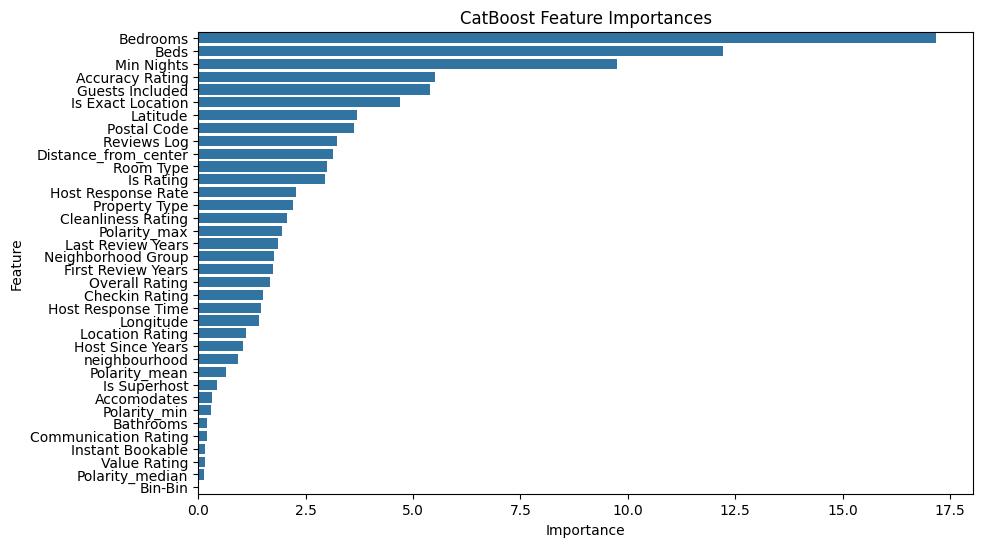

In [ ]:
# prompt: важность признаков для CatBoostRegressor и добавь график вроде # Print or plot the feature importances

# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame(feature_importance_tuples, columns=['Feature', 'Importance'])

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('CatBoost Feature Importances')
plt.show()


# LightGBM
for CatBost no nessery to make encoding and Nan

In [ ]:
X = apartments.drop(['Price'], axis=1)
y = apartments['Price']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to 'category' dtype
for feature in categorical_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

# Инициализируем и обучаем модель
model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train, categorical_feature=categorical_features)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(X_train) # Use X_train instead of train_pool
y_test_pred = model.predict(X_test) # Use X_test instead of test_pool

# Вычисляем метрики для обучающей выборки
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Вычисляем метрики для тестовой выборки
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Выводим метрики на обучающей выборке
print("Metrics on Training Set:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R^2 Score: {train_r2}")

# Выводим метрики на тестовой выборке
print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R^2 Score: {test_r2}")


# Важность признаков
importance = model.feature_importances_
feature_names = X_train.columns

# Вывод важности признаков в порядке убывания
importance_dict = dict(zip(feature_names, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4535
[LightGBM] [Info] Number of data points in the train set: 15731, number of used features: 36
[LightGBM] [Info] Start training from score 57.438561
Metrics on Training Set:
Mean Squared Error: 341.10391134325204
Mean Absolute Error: 12.710806646261494
R^2 Score: 0.77203333634757

Metrics on Test Set:
Mean Squared Error: 618.9272627368612
Mean Absolute Error: 16.39430552338664
R^2 Score: 0.5825380918089964

Feature importance in descending order:
Postal Code: 381
Bin-Bin: 357
Accomodates: 2

# XGBRegressor

## TargetEncoder

In [115]:
X = apartments.drop(columns=['Price'])
y = apartments['Price']

X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns

for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 100].index
    X[col] = X[col].replace(rare_categories, 'Other')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

# X_train[col_train_obj] = X_train[col_train_obj].fillna('abr@cadabra')
# X_test[col_test_obj] = X_test[col_test_obj].fillna('abr@cadabra')

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=10,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', xgb.XGBRegressor(
                        n_estimators=1000,
                        learning_rate=0.02,
                        max_depth=5,
                        verbosity=1))
])


# Определим eval_set для контроля обучения
# eval_set = [(X_train, y_train), (X_test, y_test)]

# # Обучим модель с выводом RMSE на каждой итерации, убираем evals_result
# model.fit(X_train, y_train, eval_set=eval_set, verbose=True)



pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))

Train RMSE: 19.33788815243981
Test RMSE: 25.701568928114934
R²: 0.5548773243289163
Train MAE: 13.108293085739062
Test MAE: 16.381663037534587


## LabelEncoder

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = apartments

# Выделяем категориальные признаки
categorical_features = df.select_dtypes(exclude='number').columns


# Закодируем категориальные переменные
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# Разделим признаки и целевую переменную
X = df.drop('Price', axis=1)
y = df['Price']

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Создадим объект модели
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=5, verbosity=1)


# Определим eval_set для контроля обучения
eval_set = [(X_train, y_train), (X_test, y_test)]

# Обучим модель с выводом RMSE на каждой итерации, убираем evals_result
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# # Обучим модель
# model.fit(X_train, y_train)

# Предсказания на тренировочной и тестовой выборках
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Вывод метрик
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

print("Training R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")


[0]	validation_0-rmse:38.27791	validation_1-rmse:38.16144
[1]	validation_0-rmse:37.88844	validation_1-rmse:37.81285
[2]	validation_0-rmse:37.51121	validation_1-rmse:37.47468
[3]	validation_0-rmse:37.14252	validation_1-rmse:37.14792
[4]	validation_0-rmse:36.78529	validation_1-rmse:36.82569
[5]	validation_0-rmse:36.43752	validation_1-rmse:36.51623
[6]	validation_0-rmse:36.10019	validation_1-rmse:36.21411
[7]	validation_0-rmse:35.76915	validation_1-rmse:35.92328
[8]	validation_0-rmse:35.45046	validation_1-rmse:35.64109
[9]	validation_0-rmse:35.13937	validation_1-rmse:35.37170
[10]	validation_0-rmse:34.83896	validation_1-rmse:35.10552
[11]	validation_0-rmse:34.54370	validation_1-rmse:34.85131
[12]	validation_0-rmse:34.26062	validation_1-rmse:34.60561
[13]	validation_0-rmse:33.98433	validation_1-rmse:34.36302
[14]	validation_0-rmse:33.71390	validation_1-rmse:34.13676
[15]	validation_0-rmse:33.45310	validation_1-rmse:33.90580
[16]	validation_0-rmse:33.19839	validation_1-rmse:33.69250
[17]	va


Feature importance in descending order:
Host Since Years: 1822.0
Postal Code: 1681.0
Accomodates: 1575.0
Longitude: 1567.0
First Review Years: 1497.0
Distance_from_center: 1458.0
Last Review Years: 1404.0
Latitude: 1161.0
Bin-Bin: 1072.0
Polarity_mean: 927.0
Host Response Rate: 898.0
Polarity_median: 895.0
neighbourhood: 820.0
Bedrooms: 784.0
Guests Included: 750.0
Reviews Log: 717.0
Polarity_max: 715.0
Overall Rating: 655.0
Min Nights: 628.0
Beds: 547.0
Room Type: 532.0
Polarity_min: 519.0
Host Response Time: 476.0
Neighborhood Group: 412.0
Value Rating: 410.0
Cleanliness Rating: 352.0
Bathrooms: 303.0
Checkin Rating: 293.0
Communication Rating: 147.0
Is Superhost: 144.0
Property Type: 134.0
Instant Bookable: 119.0
Is Exact Location: 116.0
Location Rating: 96.0
Accuracy Rating: 92.0


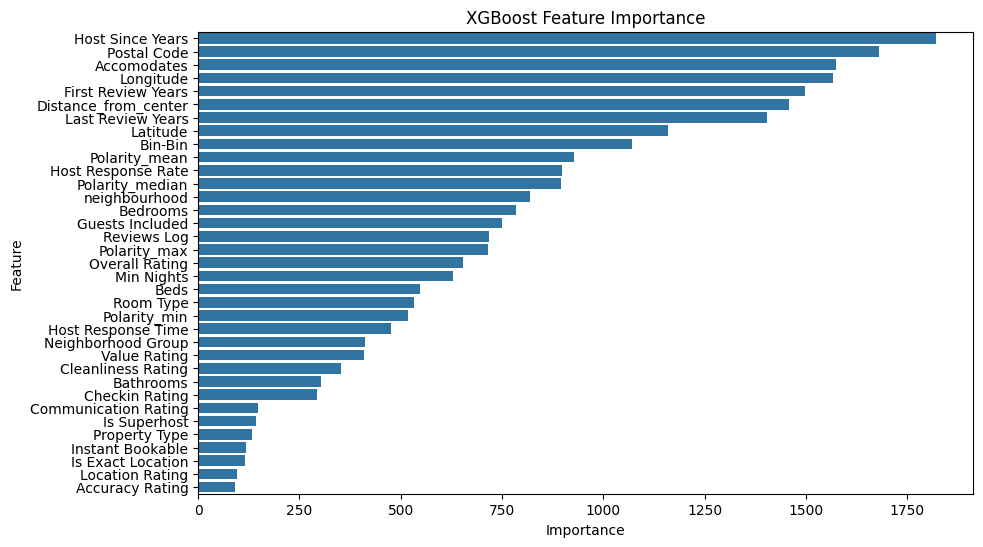

In [ ]:
# prompt: важность признаков для XGBoostRegressor и добавь график

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

# Создание DataFrame для визуализации
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance')
plt.show()


# Encoding

Converting categorical data to numerical

In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

In [ ]:
# Perform one-hot encoding and drop the first column
neighborhood_dummies = pd.get_dummies(apartments['Neighborhood Group'], prefix='Neighborhood', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
apartments = pd.concat([apartments, neighborhood_dummies], axis=1)

In [ ]:
numeric_columns = apartments.select_dtypes(include=['number']).columns

print(numeric_columns)

Index(['Host Response Time', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Is Exact Location', 'Property Type', 'Room Type',
       'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating',
       'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating',
       'Communication Rating', 'Location Rating', 'Value Rating',
       'Instant Bookable', 'Polarity_min', 'Polarity_max', 'Polarity_median',
       'Polarity_mean', 'Host Since Years', 'Last Review Years',
       'First Review Years', 'Latitude_Bin', 'Longitude_Bin', 'Price Log',
       'Reviews Log', 'Distance_from_center'],
      dtype='object')


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

numeric_columns = numeric_columns.drop(['Price Log'])

df = apartments[numeric_columns].copy()

# Предположим, что df - ваш датафрейм
X = df.drop('Price', axis=1)
y = df['Price']

# Создаем модель Лассо
model = Lasso(alpha=0.1)  # Параметр alpha регулирует степень регуляризации
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

print(f"\n Lasso")
print(f"R^2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


# Важность признаков
feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print("Feature importance using Lasso:")
print(feature_importance)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#apartments.to_excel('apartments_6.xlsx', index=False)

# import pickle
with open('apartments6.pkl', 'wb') as f:
    pickle.dump(apartments, f)


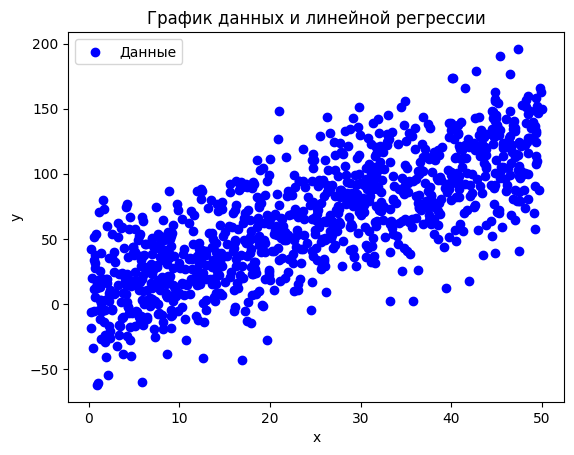

0.5846297813720505

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Случайные данные с известным R^2
np.random.seed(42)
x = np.random.rand(1000, 1) * 50  # переменная x в диапазоне от 0 до 10
y = 2.5 * x + np.random.normal(0, 30, size=(1000, 1))  # линейная зависимость с добавлением шума

# Модель линейной регрессии
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Подсчет R^2
r2 = r2_score(y, y_pred)


# Построение графика
plt.scatter(x, y, color='blue', label='Данные')
##plt.plot(x, y_pred, color='red', label=f'Линейная регрессия\n$R^2$ = {r2:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('График данных и линейной регрессии')
plt.legend()
plt.show()

r2